### kamera.csv
這是訓練資料集
資料範圍為 2013.01.01 至 2013.12.31 期間， KAMERA 體系內部分醫院的急診部門營運數據。
### submission.csv
參賽者提交的預測結果的資料格式範本

### Schema
- date - 資料記錄之日期
- tz - 資料記錄之時間區間，每四小時一個區間，共6個班次 ：[0,4),   [4,8),  [8,12), [12,16), [16,20), [20,24) 
- Hospital_PK - 醫院編號
- Level - 醫院分級 (1表示重度級急救責任醫院、2表示中度級急救責任醫院)
- PDR - 病患與醫師之比率
- PBR - 病患與床位數之比率
- total - 各級檢傷人數總和 (Target)
- A01 - 內科看診人數
- A02 - 外科看診人數
- A03 - 小兒科看診人數
- A04 - 內科候診人數
- A05 - 外科候診人數
- A06 - 小兒科候診人數
- A07 - 檢傷人數(1級)
- A08 - 檢傷人數(2級) 
- A09 - 檢傷人數(3級)
- A10 - 檢傷人數(4級)
- A11 - 檢傷人數(5級)
- A12 - 急診掛號人數(1小時內)
- A13 - 急診出院人數(1小時內)
- A14 - 急診住院人數(1小時內)
- A15 - 急診待床人數
- A16 - 目前住院候床最大時間(分)
- A17 - 呼吸器(57001B)
- C01 - 緊急待開刀數
- C02 - 急診待開刀數
- C03 - 一般待開刀數
- C04 - 當日緊急開刀數
- C05 - 當日急診開刀數
- C06 - 當日一般開刀數
- B01 - 神經內科ICU空床
- B02 - 神經外科ICU空床
- B03 - 內科ICU空床
- B04 - 外科ICU空床
- B05 - 小兒科ICU
- B06 - 空床等待ICU的人數
- light - 急診壅塞指標燈號


### 預測目標與計分方式
- 訓練資料集包含在2013年期間，11間醫院、每天6個班次（一班4小時）的急診營運資料
- 參賽者請針對「2014年第33週」（2014年8月11-17日），「每間醫院、各班次」的「各級檢傷人數總和」進行預測，並提交預測結果之 csv 檔案
- "date","tz","Hospital_PK","total"
- 2014-08-11,"[0,4)",1,0



In [2]:
%matplotlib inline

In [20]:
pd.options.display.max_columns = None

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, integrate

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 12  # that's default image size for this interactive session

In [4]:
import seaborn as sns

sns.set(color_codes=True)
np.random.seed(sum(map(ord, "distributions")))

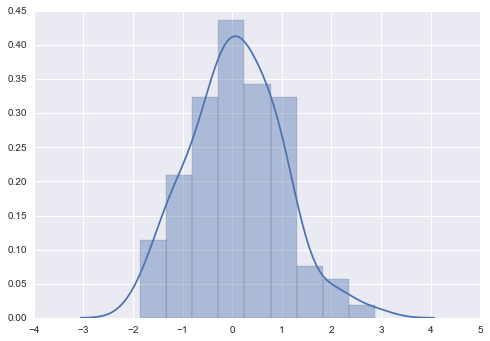

In [5]:
x = np.random.normal(size=100)
sns.distplot(x);

In [7]:
inputfile='/Users/ericali/Documents/kamera_data/kamera.csv'

rawdata = pd.read_csv(inputfile)
rawdata.head()
#n=21364

,date,tz,Hospital_PK,Level,PDR,PBR,total,A01,A02,A03,...,C04,C05,C06,B01,B02,B03,B04,B05,B06,Light
0,2013-01-01,"[0,4)",6,1,3.00,0.285714,0,4,1,1,...,0,0,0,0,0,0,0,0,0,1
1,2013-01-01,"[0,4)",22,1,8.50,0.472222,51,49,0,2,...,0,0,0,0,5,3,2,0,1,1
2,2013-01-01,"[0,4)",35,1,18.75,0.362745,74,58,8,8,...,0,1,0,0,1,1,6,5,0,3
3,2013-01-01,"[0,4)",11,2,8.00,0.617647,17,17,3,1,...,0,0,0,0,0,8,0,0,0,1
4,2013-01-01,"[0,4)",12,2,6.50,0.520000,13,8,4,1,...,0,0,0,0,0,0,3,1,0,1


In [21]:
rawdata.describe()

,Hospital_PK,Level,PDR,PBR,total,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,C01,C02,C03,C04,C05,C06,B01,B02,B03,B04,B05,B06,Light
count,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000,21364.000000
mean,17.172627,1.626287,9.531698,0.558674,36.995834,30.354288,4.280659,2.432878,0.514323,0.258285,0.125211,1.674125,7.415933,25.520595,2.243306,0.141874,6.438448,6.672580,1.256694,18.984039,11450.360794,0.566654,0.291706,0.385508,12.040957,0.561084,1.344692,24.496209,0.323160,0.480060,3.332896,1.247519,2.405168,0.173563,1.654465
std,11.233500,0.483800,7.991048,0.323712,43.793464,37.393886,4.727510,3.179952,0.883321,0.694189,0.441285,2.770465,11.989584,29.674031,2.808625,0.435890,4.711576,6.281998,2.099370,29.974015,81973.494357,1.549358,1.120049,0.873847,30.241975,1.898803,2.606490,36.707878,0.969818,1.229247,4.576072,2.053526,3.434060,0.722850,1.055215
min,1.000000,1.000000,0.500000,0.025000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-837.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.000000,1.000000,5.000000,0.300000,8.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,14.000000,2.000000,7.500000,0.537815,18.000000,13.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.000000,1.000000,0.000000,5.000000,5.000000,0.000000,4.000000,695.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
75%,22.000000,2.000000,11.000000,0.745098,54.000000,43.000000,6.000000,4.000000,1.000000,0.000000,0.000000,2.000000,10.000000,36.000000,3.000000,0.000000,9.000000,10.000000,2.000000,26.000000,3738.250000,0.000000,0.000000,0.000000,11.000000,0.000000,2.000000,32.000000,0.000000,0.000000,5.000000,2.000000,4.000000,0.000000,3.000000
max,40.000000,2.000000,54.250000,2.933333,226.000000,185.000000,37.000000,25.000000,8.000000,10.000000,22.000000,20.000000,74.000000,158.000000,21.000000,6.000000,39.000000,86.000000,21.000000,168.000000,774454.000000,17.000000,19.000000,11.000000,228.000000,23.000000,24.000000,211.000000,9.000000,11.000000,30.000000,14.000000,21.000000,11.000000,4.000000


In [127]:
rawdata.dtypes

date            object
tz              object
Hospital_PK      int64
Level            int64
PDR            float64
PBR            float64
total            int64
A01              int64
A02              int64
A03              int64
A04              int64
A05              int64
A06              int64
A07              int64
A08              int64
A09              int64
A10              int64
A11              int64
A12              int64
A13              int64
A14              int64
A15              int64
A16              int64
A17              int64
C01              int64
C02              int64
C03              int64
C04              int64
C05              int64
C06              int64
B01              int64
B02              int64
B03              int64
B04              int64
B05              int64
B06              int64
Light            int64
dtype: object

In [19]:
#Determine if ANY Value in a Series is Missing
rawdata.isnull().values.any()

False

In [23]:
rawdata['date_2'] = pd.to_datetime(rawdata['date'])
rawdata['date_2'].head(3)

0   2013-01-01
1   2013-01-01
2   2013-01-01
Name: date_2, dtype: datetime64[ns]

In [51]:
rawdata.groupby(rawdata.Hospital_PK).size()

Hospital_PK
1     1962
6     2047
11    2052
12    1531
13    2022
14    1847
16    1904
17    1998
22    1927
35    2048
40    2026
dtype: int64

In [54]:
pd.crosstab(rawdata.Level, rawdata.Hospital_PK)

Hospital_PK,1,6,11,12,13,14,16,17,22,35,40
Level,,,,,,,,,,,
1,1962,2047,0,0,0,0,0,0,1927,2048,0
2,0,0,2052,1531,2022,1847,1904,1998,0,0,2026


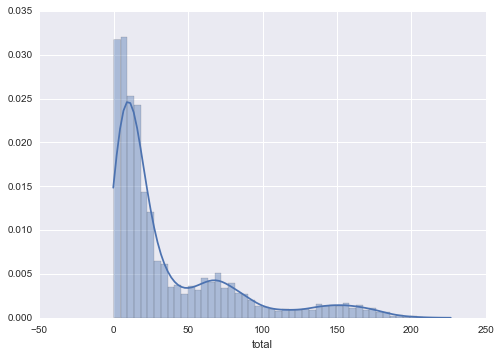

In [17]:
#total - 各級檢傷人數總和
sns.distplot(rawdata.total);

In [ ]:
df1 = pd.DataFrame(rawdata, columns=["A01", "A02"])
sns.pairplot(rawdata);

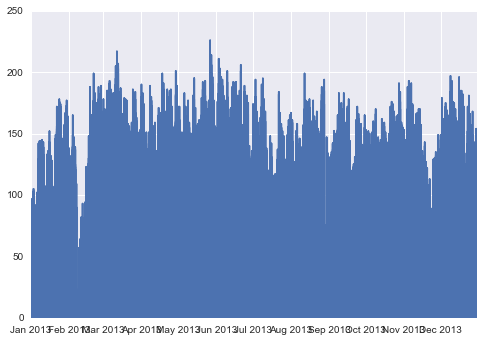

In [35]:
rawdata.set_index(['date_2'], inplace=True)

plt.plot(rawdata.index, rawdata.total)

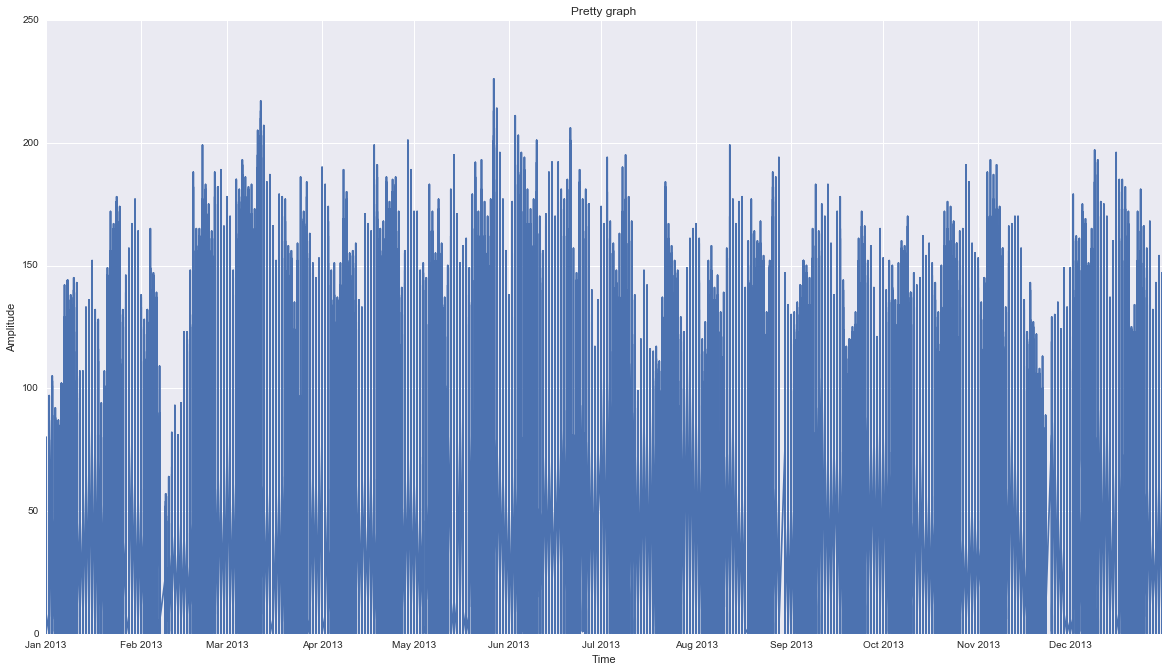

In [39]:
# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
setup_graph(title='Pretty graph', x_label='Time', y_label='Amplitude', fig_size=(20,11))

plt.plot(rawdata.index, rawdata.total)

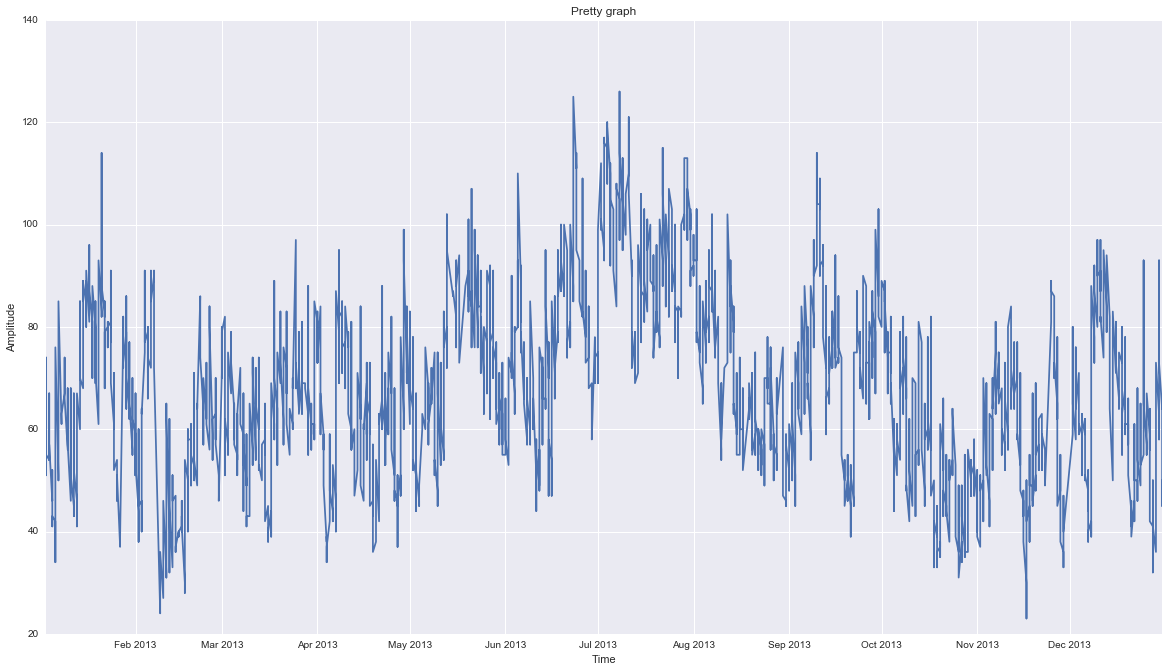

In [69]:
# no1醫院,
hopital1 = rawdata[rawdata['Hospital_PK'] == 1]

setup_graph(title='Pretty graph', x_label='Time', y_label='Amplitude', fig_size=(20,11))

plt.plot(hopital1.index, hopital1.total)

In [101]:
#hopital1 = rawdata[rawdata['Hospital_PK'] == 1]

#test1 = hopital1[['total','tz','date']]

#test1.plot()

ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()

df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

df = df.cumsum()
df.head()

,A,B,C,D
2000-01-01,0.104758,0.400523,-0.056314,1.588277
2000-01-02,-1.525923,0.797807,-1.378603,0.993415
2000-01-03,-0.875151,1.128914,-2.160991,0.526203
2000-01-04,-1.305301,0.952640,-1.729762,0.307655
2000-01-05,0.416234,2.143724,0.299391,0.160165


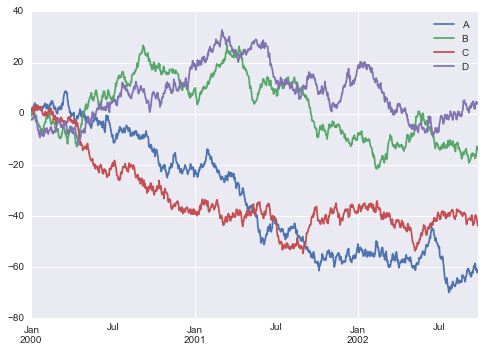

In [99]:
plt.figure(); df.plot(); plt.legend(loc='best')

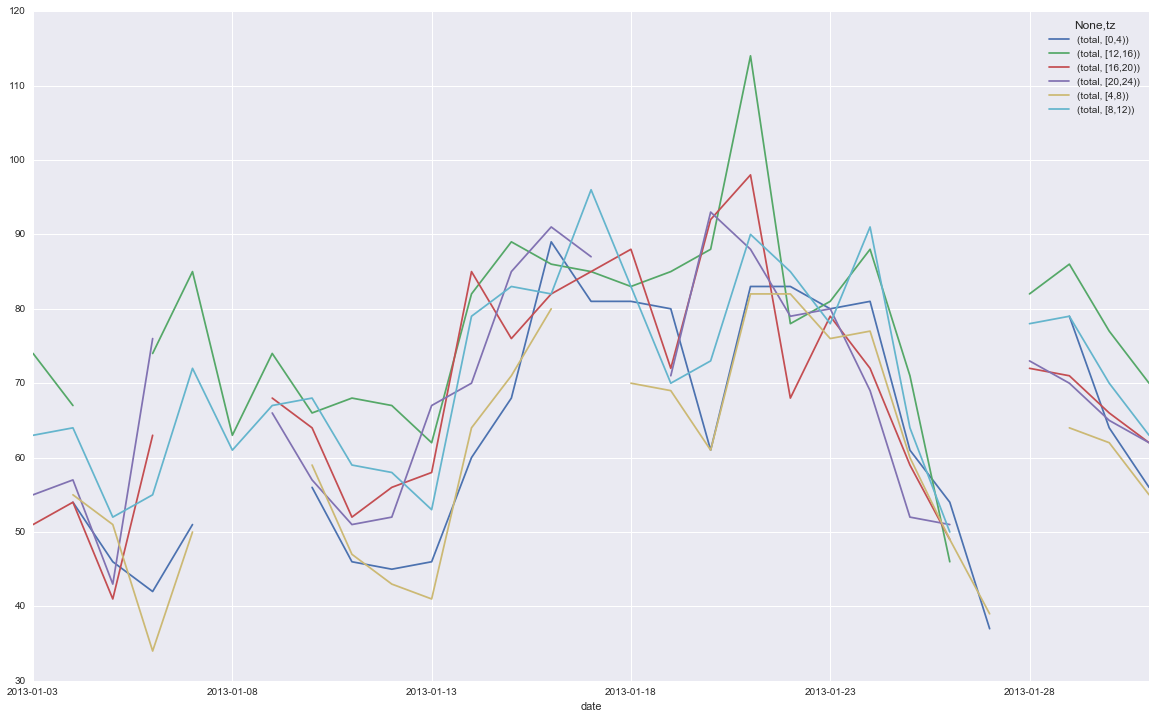

In [126]:
tmp = rawdata[(rawdata['Hospital_PK'] == 1) & (rawdata['date'] < '2013-02-01')]

tz_temp = pd.pivot_table(tmp, index=["date"], columns=["tz"], values=["total"])
tz_temp.plot()

# Data Cleaning
### 1. Remove duplicate features
Columns having the same value distribution or variance
### 2. Remove constant variables
### 3. Remove near-zero variance
### 4. Check missing value then apply imputation

In [136]:
rawdata.corr()

,Hospital_PK,Level,PDR,PBR,total,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,A11,A12,A13,A14,A15,A16,A17,C01,C02,C03,C04,C05,C06,B01,B02,B03,B04,B05,B06,Light
Hospital_PK,1.000000,0.075694,0.490109,0.080946,0.328211,0.317950,0.218485,0.221588,-0.175232,0.070390,-0.023558,0.081453,0.323296,0.348071,-0.024506,0.027090,0.070124,0.060856,0.200600,0.306016,-0.017460,0.327043,0.352208,-0.146866,0.267968,0.328745,-0.189275,0.003775,-0.397888,0.148451,-0.032933,0.126640,0.324950,0.294061,0.230604
Level,0.075694,1.000000,-0.441341,-0.088146,-0.612047,-0.657140,-0.388762,-0.496496,-0.100843,-0.035660,-0.020899,-0.595126,-0.632245,-0.586330,-0.048347,-0.091735,-0.293852,-0.498392,-0.269591,-0.585978,0.070053,-0.393039,-0.306407,-0.110291,-0.218647,-0.267227,-0.262480,-0.316263,-0.258582,-0.505180,0.308778,-0.163390,-0.359573,-0.310840,-0.121835
PDR,0.490109,-0.441341,1.000000,0.468960,0.868161,0.868943,0.717784,0.638020,0.029959,0.223081,0.069413,0.599450,0.837045,0.868867,0.188358,0.026118,0.430881,0.338425,0.311034,0.860470,-0.040637,0.656996,0.536160,-0.004482,0.644638,0.453756,0.024964,0.316468,-0.023100,0.397989,-0.245543,0.224838,0.512382,0.456294,0.534221
PBR,0.080946,-0.088146,0.468960,1.000000,0.397200,0.392029,0.496536,0.286596,0.099452,0.157342,0.056794,0.206954,0.267562,0.405181,0.553158,0.083738,0.311776,0.219545,0.118145,0.344949,-0.087714,0.159925,0.121297,0.093190,0.178824,0.095729,0.037701,0.152938,0.052105,0.106216,-0.328755,0.125388,-0.001787,0.121944,0.755952
total,0.328211,-0.612047,0.868161,0.397200,1.000000,0.991341,0.784683,0.724253,0.133762,0.225381,0.076309,0.769503,0.951275,0.991221,0.285296,0.094910,0.568126,0.423682,0.486748,0.966990,-0.041079,0.693377,0.596156,0.099435,0.542178,0.507216,0.218392,0.518145,0.148937,0.560611,-0.202904,0.328043,0.581975,0.492213,0.474545
A01,0.317950,-0.657140,0.868943,0.392029,0.991341,1.000000,0.744570,0.683419,0.108912,0.215512,0.056290,0.761621,0.948100,0.981855,0.270985,0.092275,0.531441,0.436782,0.472764,0.968838,-0.045773,0.692676,0.593583,0.079322,0.544619,0.498845,0.194696,0.507236,0.125939,0.557413,-0.214781,0.310529,0.570009,0.498789,0.464573
A02,0.218485,-0.388762,0.717784,0.496536,0.784683,0.744570,1.000000,0.499968,0.060140,0.240174,0.046026,0.542791,0.727820,0.788600,0.258136,0.018339,0.518036,0.373470,0.441805,0.746991,-0.058693,0.558626,0.558390,0.098994,0.460466,0.494478,0.150127,0.461963,0.125961,0.418446,-0.217667,0.243421,0.399897,0.387644,0.498149
A03,0.221588,-0.496496,0.638020,0.286596,0.724253,0.683419,0.499968,1.000000,0.134510,0.112713,0.129163,0.625369,0.711067,0.706456,0.170561,0.039307,0.496431,0.382895,0.308091,0.671933,-0.008646,0.513444,0.373634,0.079811,0.347210,0.327944,0.219150,0.315362,0.185775,0.414247,-0.235517,0.284044,0.487768,0.303792,0.330470
A04,-0.175232,-0.100843,0.029959,0.099452,0.133762,0.108912,0.060140,0.134510,1.000000,0.059541,0.124193,0.188442,0.091337,0.123233,0.193407,0.093380,0.403662,0.107148,0.140586,0.083717,0.028792,0.004262,-0.042878,0.144819,-0.064006,-0.018676,0.320491,0.171371,0.186446,0.121101,-0.017589,0.067412,0.061588,-0.011958,0.048349
A05,0.070390,-0.035660,0.223081,0.157342,0.225381,0.215512,0.240174,0.112713,0.059541,1.000000,0.032714,0.149399,0.217170,0.218476,0.129921,0.010541,0.245442,0.078001,0.151366,0.229312,-0.008388,0.189025,0.180754,-0.029187,0.125977,0.139349,0.046696,0.131881,-0.040619,0.083437,-0.015162,0.028147,0.083341,0.079132,0.175263


In [137]:
# p value for pearson coef
n = 21364
r = rawdata.corr()
t = r*np.sqrt((n-2)/(1-r*r))

import scipy.stats as ss
ss.t.cdf(t, n-2)

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   9.47666969e-72],
       [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       ..., 
       [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   9.47666969e-72,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]])

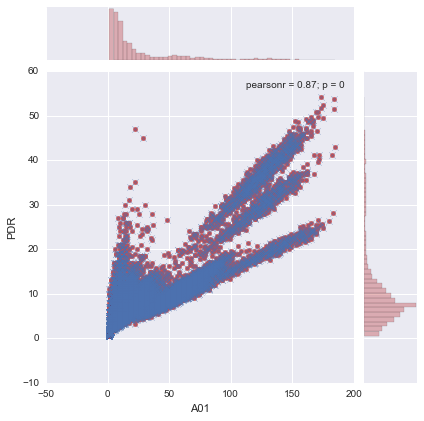

In [138]:
# 1. Remove duplicate features
# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(rawdata, columns=['A01', 'PDR'])
df2 = pd.DataFrame(rawdata, columns=['A01', 'PDR'])

# plot
# ========================================   
graph = sns.jointplot(x=df1.A01, y=df1.PDR, color='r')

graph.x = df2.A01
graph.y = df2.PDR
graph.plot_joint(plt.scatter, marker='x', c='b', s=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116e576d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117c4eb10>]], dtype=object)

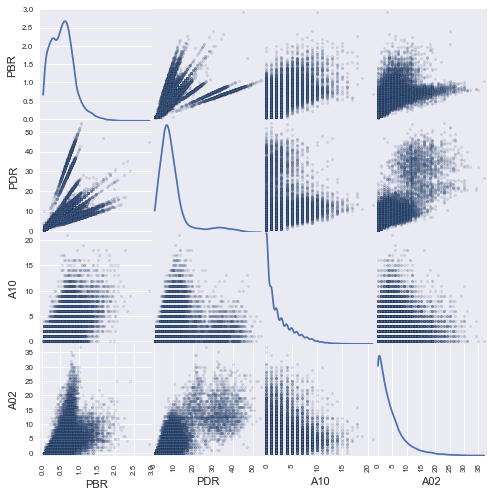

In [135]:
from pandas.tools.plotting import scatter_matrix

df_dc2 = rawdata[['PBR','PDR','A10', 'A02']]
scatter_matrix(df_dc2, alpha=0.2, figsize=(8, 8), diagonal='kde')

In [ ]:
# Remove constant variables
# Candidate: A05, A06, A07, A11, A17, B01, B02, B04, C01, C04
# Elect: 


# Feature Engineering
### Data transformation
### Feature encoding
### Feature extraction
### Feature selection: PCA, truncated SVD

### PLT examples

In [ ]:
#stacked column chart
var = df.groupby([‘bmi’, ‘gender’]).sales.sum()
var.unstack().plot(kind=‘bar’, stacked=True, color=[‘red’,’blue’],grid=False)

#bubble plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(df[‘age’],df[‘sales’],s=df[‘income’])
plt.show()

#heat map
import bumpy as np
data = np.random.rand(4,2)
rows = list(‘1234’) #row
categories columns = list(‘MF’) #column categories
fig, ax = plt.subplots()
ax.pcolor(data,cmap=plt.cm.Reds, edgecolors=‘k’)
ax.set_xticks(np.arrange(0,2)+0.5)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels(columns, minor=False, fontsize=20)
ax.set_yticklabels(rows, minor=False, fontsize=20)
plt.show()